In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf
import os

!git clone https://github.com/e9t/nsmc.git
os.listdir('nsmc')

fatal: destination path 'nsmc' already exists and is not an empty directory.


['ratings_train.txt',
 '.git',
 'ratings.txt',
 'README.md',
 'raw',
 'synopses.json',
 'ratings_test.txt',
 'code']

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('nsmc/'+'ratings_train.txt')
test_data = pd.read_table('nsmc/'+'ratings_test.txt')

train_data.head(20)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [3]:
print("학습데이터 고유값 :",train_data['document'].nunique())
print("테스트데이터 고유값 :",test_data['document'].nunique())
print("라벨데이터 고유값 :",test_data['label'].nunique()) # label 0: negative / 1: positive

학습데이터 고유값 : 146182
테스트데이터 고유값 : 49157
라벨데이터 고유값 : 2


In [4]:
#중복데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print("학습데이터 고유값 :",train_data['document'].nunique())
test_data.drop_duplicates(subset=['document'], inplace=True)
print("테스트데이터 고유값 :",test_data['document'].nunique())

학습데이터 고유값 : 146182
테스트데이터 고유값 : 49157


In [5]:
#train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
#train_data[:5]

In [6]:
#test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
#test_data[:5]

In [7]:
#결측치 확인
print('학습데이터 결측치 여부 :{}'.format(train_data.isnull().values.any()))
print('테스트데이터 결측치 여부 :{}'.format(test_data.isnull().values.any()))

학습데이터 결측치 여부 :True
테스트데이터 결측치 여부 :True


In [8]:
#결측치 제거
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())
test_data = test_data.dropna(how = 'any')
print(test_data.isnull().values.any())
#결측치 확인
print('학습데이터 결측치 여부 :{}'.format(train_data.isnull().values.any()))
print('테스트데이터 결측치 여부 :{}'.format(test_data.isnull().values.any()))

False
False
학습데이터 결측치 여부 :False
테스트데이터 결측치 여부 :False


19
문장길이 평균 :  35.981338331668745
문장길이 최대 :  146
문장길이 표준편차 :  29.49113203149937
pad_sequences maxlen :  94
전체 문장의 0.9323719746617231%가 maxlen 설정값 이내에 포함됩니다. 
sentence_length :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


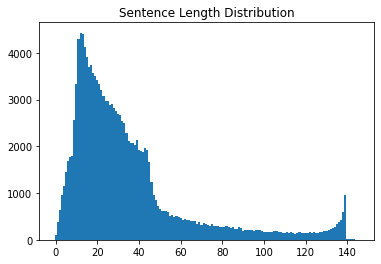

In [9]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    
    # 문장 최소 길이 찾기
    if min_len > length: 
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length: 
        max_len = length
        
    sum_len += length

num_sentences = [len(sentence) for sentence in train_data['document']]
print(num_sentences[0])
num_sentences = np.array(num_sentences)

print('문장길이 평균 : ', np.mean(num_sentences))
print('문장길이 최대 : ', np.max(num_sentences))
print('문장길이 표준편차 : ', np.std(num_sentences))

#평균 + 표준편차*2
max_sentence = np.mean(num_sentences) + 2 * np.std(num_sentences)
maxlen = int(max_sentence)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_sentences < max_sentence) / len(num_sentences)))

sentence_length = np.zeros((max_len), dtype=np.int)
print("sentence_length : ",sentence_length)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1 

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [10]:
max_sentence = np.mean(num_sentences) + np.std(num_sentences)
maxlen = int(max_sentence)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_sentences < max_sentence) / len(num_sentences)))

pad_sequences maxlen :  65
전체 문장의 0.8742252808143274%가 maxlen 설정값 이내에 포함됩니다. 


문장을 65자 이하로 해도 train data의 87%가 포함됩니다.

In [11]:
#결측치제거 + 중복값제거 + 너무 긴 문장이 제거된 데이터프레임을 다시 만들어줍니다.
train_list = [s for s in train_data['document'] if (len(s) <= 40)]
test_list = [s for s in test_data['document'] if (len(s) <= 40)]

train_list = list(set(train_list))
test_list = list(set(test_list))

train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)

new_train_df = pd.merge(train_data, train_df, how='inner', left_on='document', right_on=0)
new_test_df = pd.merge(test_data, test_df, how='inner', left_on='document', right_on=0)

train_data = new_train_df[['id', 'document', 'label']]
test_data = new_test_df[['id', 'document', 'label']]

display(train_data.head(20))
display(test_data.head(20))

print("훈련데이터 : ",len(train_data))
print("테스트데이터 : ",len(test_data))

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
5,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
6,9008700,걍인피니트가짱이다.진짜짱이다♥,1
7,5957425,울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해,0
8,6852435,ㄱ냥 매번 긴장되고 재밋음ㅠㅠ,1
9,4891476,굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐,0


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,7898805,"음악이 주가 된, 최고의 음악영화",1
5,6315043,진정한 쓰레기,0
6,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
7,7462111,괜찮네요오랜만포켓몬스터잼밌어요,1
8,8425305,한국독립영화의 한계 그렇게 아버지가 된다와 비교됨,0
9,9629375,눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다.,1


훈련데이터 :  104975
테스트데이터 :  35435


In [12]:
corpus = []
for sentence in train_data['document']:
    corpus.append(sentence)

corpus

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '걍인피니트가짱이다.진짜짱이다♥',
 '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해',
 'ㄱ냥 매번 긴장되고 재밋음ㅠㅠ',
 '굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐',
 '약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.',
 '보면서 웃지 않는 건 불가능하다',
 '절대 평범한 영화가 아닌 수작이라는걸 말씀드립니다.',
 '주제는 좋은데 중반부터 지루하다',
 'kl2g 고추를 털어버려야 할텐데',
 '카밀라벨 발연기',
 '재밋는뎅',
 '센스있는 연출력..탁월한 캐스팅..90년대의 향수.. 그래서 9점..',
 '졸쓰레기 진부하고말도안됌ㅋㅋ 아..시간아까워',
 '재밌는데 별점이 왜이리 낮은고',
 '1%라도 기대했던 내가 죄인입니다 죄인입니다....',
 '아직도 이 드라마는 내인생의 최고!',
 '패션에 대한 열정! 안나 윈투어!',
 '키이라 나이틀리가 연기하고자 했던건 대체 정신장애일까 틱장애일까',
 '허허...원작가 정신나간 유령이라... 재미있겠네요!',
 '포스터는 있어보이는데 관객은 114명이네',
 '이 영화가 왜 이렇게 저평가 받는지 모르겠다',
 '단순하면서 은은한 매력의 영화',
 '오게두어라! 서리한이 굶주렸다!',
 '평점에속지마시길시간낭비 돈낭비임',
 '난 우리영화를 사랑합니다....^^;',
 '야 세르게이! 작은고추의 매운맛을 보여주마! 포퐁저그 콩진호가 간다',
 '이렇게 가슴시리게 본 드라마가 또 있을까? 감동 그 자체!',
 '재미있어요',
 '전 좋아요',
 '최고',
 '심심한영화.',
 '백봉기 언제나오나요?',
 '보는내내 그대로 들어맞는 예측 카리

In [13]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 375819 Dec 20 12:58 korean_spm.model
-rw-r--r-- 1 root root 145251 Dec 20 12:58 korean_spm.vocab


In [14]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1670, 10, 410, 16, 1594, 10, 149, 13, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [15]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        if type(sen) is not str :
            print("is not string : {}".format(sen))
            continue
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [16]:
my_corpus = ['아버지가 방에 들어가신다.','나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1670   10 1102   16 4646  149   13    4    0    0]
 [ 467 2823   14 1020 2246    4    0    0    0    0]
 [1444 2111  222  587   10    3   19 7888  842    7]]


In [17]:
tensor, word_index, index_word = sp_tokenize(s, corpus[:5])
print(corpus[:5])
print(tensor)

['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '원작의 긴장감을 제대로 살려내지못했다.']
[[  45  905    5   28 2071   64 1778    0    0    0    0    0    0    0
     0]
 [1172    7 4777  170 1165   29  281   39  171  512  371 1412 6302  682
   374]
 [  22  454 7523  285 4682  638 2255 1598  329    0    0    0    0    0
     0]
 [2216   12  213  185 4310    3    5 5591  970   96    5  655 5834    0
     0]
 [3139  711   14  673 3574  214   20  463  182    4    0    0    0    0
     0]]


In [18]:
X_train,X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
X_test,X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])

In [19]:
# 현재 list 상태 ==> ndarray로 바꿔주기
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [20]:
print("학습데이터 :",len(X_train))
print("타겟데이터 :",len(y_train))

학습데이터 : 104975
타겟데이터 : 104975


In [21]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(train_input[:3])
print(val_input[:3])

[[2593   19   15 5203   15 6262   19    3 1042    4 2322    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 136   22 1489  133    5  655  280  862    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  22  813 2830    3    5    3 2516 2798   16   22  333  285   11    7
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[6647   16 5969    3 2050   25  122   69  614  319  272   43  154   91
  1803   10  517  911  135   36    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [2560 3895   70   49  116   16 1344 1563 1399 2548 1607    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 

In [22]:
vocab_size = 8000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 128,881
Trainable params: 128,881
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_input, train_target, epochs=10, validation_data=(val_input, val_target))

Epoch 1/10
2625/2625 [==============================] - 28s 10ms/step - loss: 0.6526 - accuracy: 0.5533 - val_loss: 0.3940 - val_accuracy: 0.8231
Epoch 2/10
2625/2625 [==============================] - 24s 9ms/step - loss: 0.3459 - accuracy: 0.8511 - val_loss: 0.3673 - val_accuracy: 0.8333
Epoch 3/10
2625/2625 [==============================] - 24s 9ms/step - loss: 0.2991 - accuracy: 0.8692 - val_loss: 0.3651 - val_accuracy: 0.8402
Epoch 4/10
2625/2625 [==============================] - 24s 9ms/step - loss: 0.2682 - accuracy: 0.8834 - val_loss: 0.3929 - val_accuracy: 0.8404
Epoch 5/10
2625/2625 [==============================] - 24s 9ms/step - loss: 0.2439 - accuracy: 0.8922 - val_loss: 0.4121 - val_accuracy: 0.8295
Epoch 6/10
2625/2625 [==============================] - 24s 9ms/step - loss: 0.2251 - accuracy: 0.9023 - val_loss: 0.4099 - val_accuracy: 0.8381
Epoch 7/10
2625/2625 [==============================] - 24s 9ms/step - loss: 0.2063 - accuracy: 0.9121 - val_loss: 0.4285 - val_a

In [24]:
result = model.evaluate(X_test,  y_test, verbose=2)
print(result)

1108/1108 - 4s - loss: 0.5006 - accuracy: 0.8189
[0.5005763173103333, 0.8188796639442444]


학습 정확도는 83%정도 나오네요

In [25]:
my_corpus = ['최고의 영화에요!']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model.predict(tensor))))

my_corpus = ['쓰레기같은 영화에요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model.predict(tensor))))

my_corpus = ['완전 인생영화 발견 10점 만점에 10점']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model.predict(tensor))))

긍정적인 리뷰일 확률 : 0.8521670699119568
긍정적인 리뷰일 확률 : 0.11358560621738434
긍정적인 리뷰일 확률 : 0.9825013279914856


In [26]:
my_corpus = ['진짜 개구리다... 감독은 다신 영화 안만들었음 좋겠음']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model.predict(tensor))))

긍정적인 리뷰일 확률 : 0.1081089973449707


긍정적인 리뷰인지 부정적인 리뷰인지도 그럭저럭 잘 구분해냅니다, 길수록 더 잘 구분하는 것 같네요    
다음은 이전에 작성한 Mecab토크나이저를 이용한 모델과 비교해보겠습니다.

In [27]:
train_data2 = pd.read_table('~/aiffel/GoingDeeper/Project01/sentiment_classification/data/ratings_train.txt')
test_data2 = pd.read_table('~/aiffel/GoingDeeper/Project01/sentiment_classification/data/ratings_test.txt')

train_data2.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [28]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() #중복 제거
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]   
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data2, test_data2)

In [29]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [30]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [31]:
##### 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
#word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

#index_to_word = {index:word for word, index in word_to_index.items()}

In [32]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [33]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [34]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [36]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [37]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=12  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/12
266/266 [==============================] - 5s 13ms/step - loss: 0.6188 - accuracy: 0.6644 - val_loss: 0.3750 - val_accuracy: 0.8443
Epoch 2/12
266/266 [==============================] - 3s 11ms/step - loss: 0.3503 - accuracy: 0.8555 - val_loss: 0.3409 - val_accuracy: 0.8518
Epoch 3/12
266/266 [==============================] - 3s 11ms/step - loss: 0.3103 - accuracy: 0.8721 - val_loss: 0.3358 - val_accuracy: 0.8540
Epoch 4/12
266/266 [==============================] - 3s 11ms/step - loss: 0.2931 - accuracy: 0.8796 - val_loss: 0.3339 - val_accuracy: 0.8553
Epoch 5/12
266/266 [==============================] - 3s 11ms/step - loss: 0.2801 - accuracy: 0.8848 - val_loss: 0.3359 - val_accuracy: 0.8550
Epoch 6/12
266/266 [==============================] - 3s 11ms/step - loss: 0.2700 - accuracy: 0.8899 - val_loss: 0.3417 - val_accuracy: 0.8558
Epoch 7/12
266/266 [==============================] - 3s 11ms/step - loss: 0.2591 - accuracy: 0.8950 - val_loss: 0.3474 - val_accuracy: 0.8539

In [39]:
result = model2.evaluate(x_test,  y_test, verbose=2)
print(result)

1537/1537 - 5s - loss: 0.3944 - accuracy: 0.8458
[0.39435043931007385, 0.8458205461502075]


In [40]:
my_corpus = ['최고의 영화에요!']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model2.predict(tensor))))

my_corpus = ['쓰레기같은 영화에요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model2.predict(tensor))))

my_corpus = ['완전 인생영화 발견 10점 만점에 10점']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model2.predict(tensor))))

긍정적인 리뷰일 확률 : 0.49156075716018677
긍정적인 리뷰일 확률 : 0.17842984199523926
긍정적인 리뷰일 확률 : 0.9727952480316162


In [41]:
my_corpus = ['진짜 개구리다... 감독은 다신 영화 안만들었음 좋겠음']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print("긍정적인 리뷰일 확률 : {}".format(float(model.predict(tensor))))

긍정적인 리뷰일 확률 : 0.1081089973449707


## 회고
당연히 sentencePiece를 이용한 토크나이징이 더 좋은 결과를 보여줄 줄 알았지만  
Mecab 형태소분석기를 이용한 토크나이징이 오히려 더 빠르고 높은 정확도를 보였습니다.
딥러닝에서 랜덤시드에 따라서 학습이 잘되고 잘 안되고가 편차가 크다는 사실도 확인하였습니다  
어떤 시도에서는 2번의 epoch만에 최저점의 loss값까지 도달하는가 하면 어떤 시도에서는 10epoch까지 적절한 gradient값을 찾지 못하고  
학습이 고착되는 경우도 있었습니다.(특히 sentencepiece를 사용한 모델의 경우)  
그래서 Mecab이 최종 predict에서 조금 아쉬운 결과를 보여주긴 했지만 실제예측에서는 sentencepiece보다 밀린다고 하기 어렵습니다.  
따라서 이번 프로젝트에서는 꼭 최신의 방법이 모든 상황에서 최선은 아니라는 교훈을 얻었습니다.  
더 시간이 있다면 좀 더 다양한 변수를 주고 실험해봤을때 결과가 어떻게 나오는지 보는것도 좋을 것 같습니다.  